In [6]:
#import libraries
import pandas as pd
import numpy as np
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

from feature_engine.datetime import DatetimeFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures
from feature_engine.timeseries.forecasting import (
    LagFeatures,
    WindowFeatures,
)

In [7]:
train_df = pd.read_csv("/Users/cevikyi/Downloads/product forecast/train.csv")
#test_df = pd.read_csv("/Users/cevikyi/Downloads/product forecast/test.csv")

EDA

1. check shape
2. check null values
3. check for outliers
4. check unique store and items
5. look for trend and seasonality components

In [8]:
print(train_df.shape)

(913000, 4)


In [9]:
print(train_df.head())
print(train_df.date.min(),train_df.date.max())


         date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
3  2013-01-04      1     1     13
4  2013-01-05      1     1     10
2013-01-01 2017-12-31


In [10]:
# Plot the time series of sales for each store-item combination
print(train_df.isnull().sum())


date     0
store    0
item     0
sales    0
dtype: int64


In [11]:
# Create a copy of the train data for EDA
df = train_df.copy()

# Group by store_id and item_id
df_store_item = df.groupby(['store'])

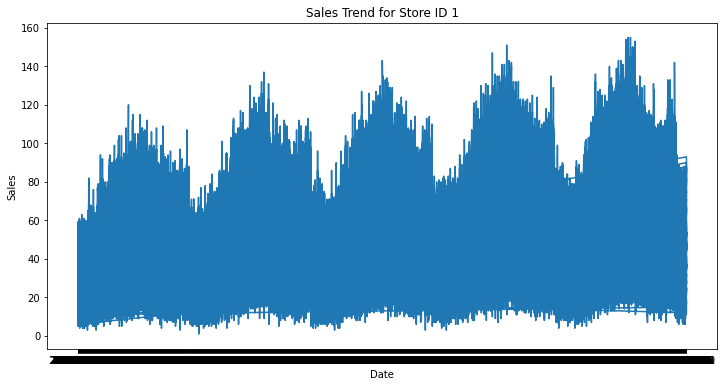

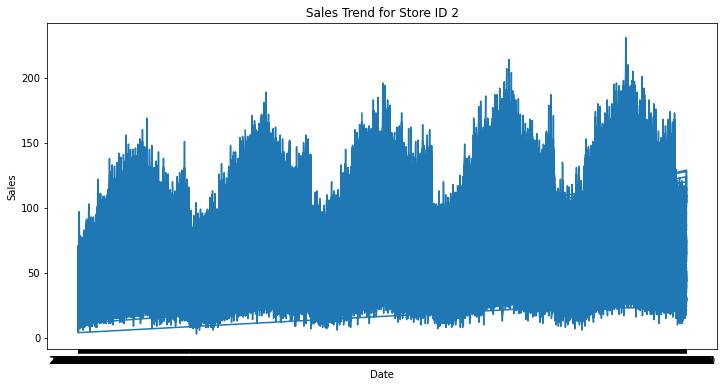

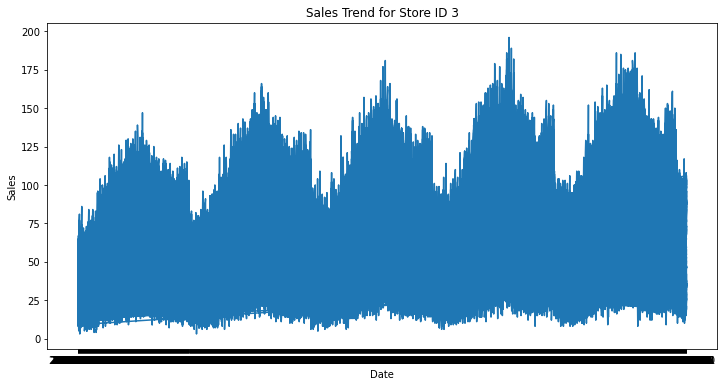

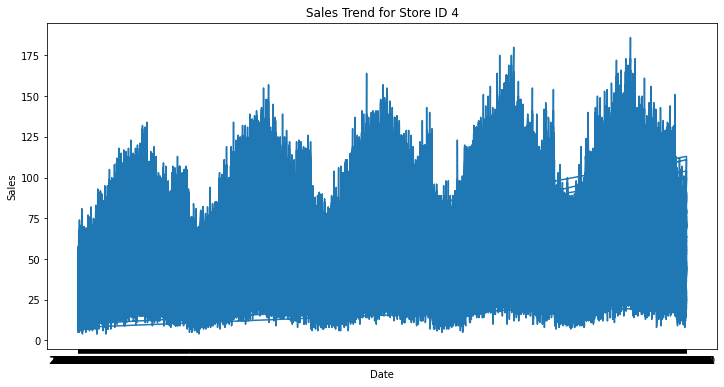

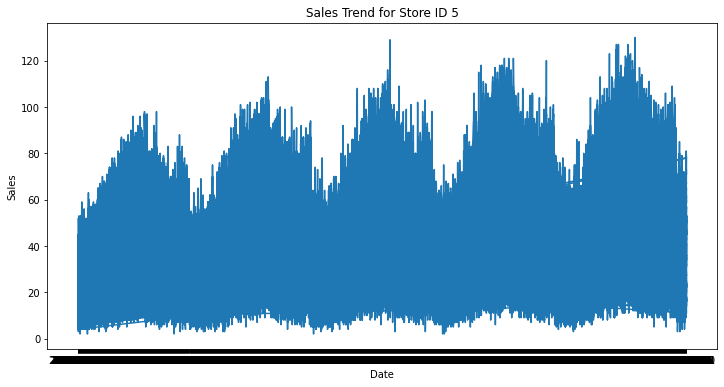

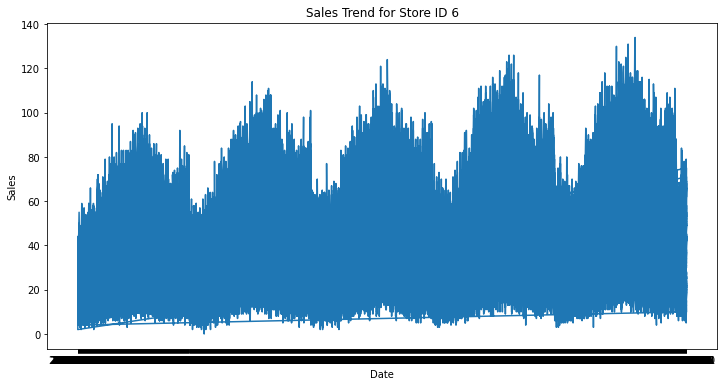

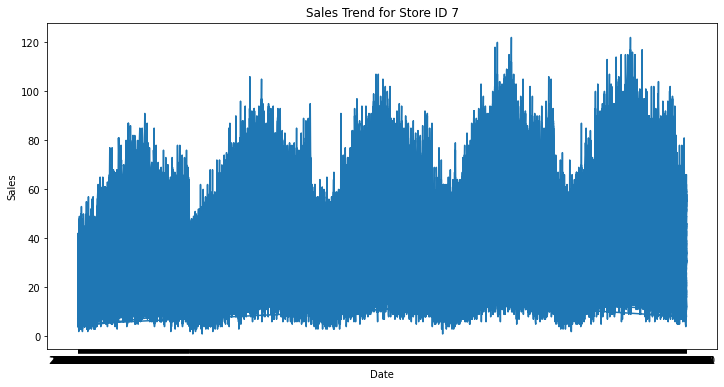

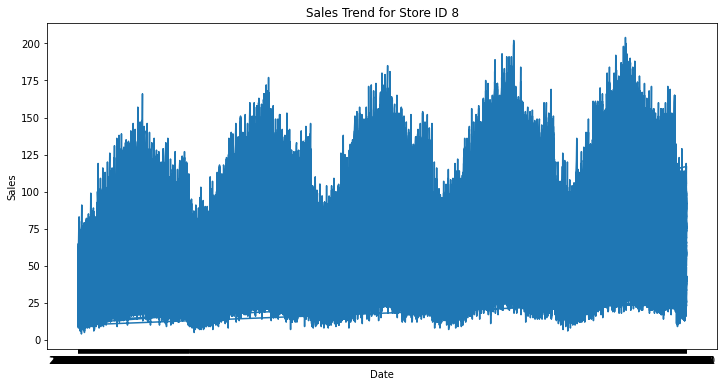

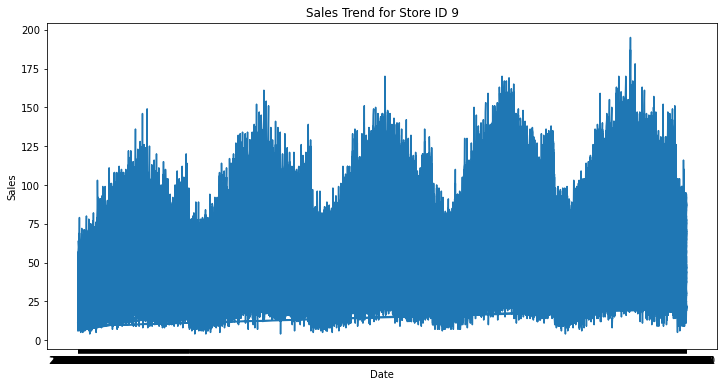

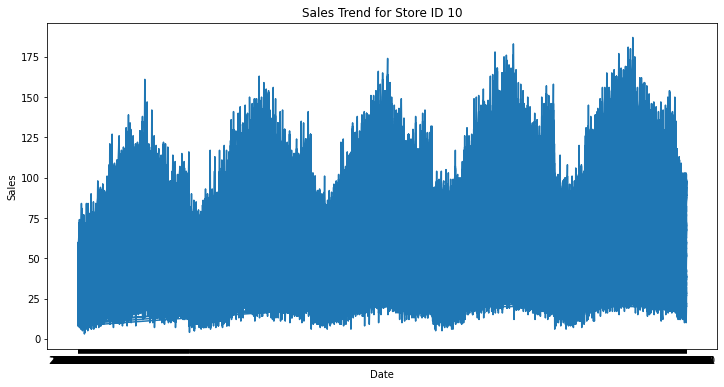

In [12]:
# Plot the time series of sales for each store-item combination
for store_id in df_store_item.groups:
    df_temp = df_store_item.get_group((store_id))
    sales = df_temp['sales']
    date = df_temp['date']

    plt.figure(figsize=(12, 6))
    plt.plot(date, sales)
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title('Sales Trend for Store ID {}'.format(store_id))
    plt.show()

Assign data for observation and forecast period

In [13]:
# Assign observation period
date_range = pd.date_range(start='2013-01-01', end='2017-12-31')

# Check if every date in the range exists in the DataFrame
all_dates_exist = all(pd.to_datetime(train_df['date']).isin(date_range))

# Print the result
if all_dates_exist:
    print("Every day from 2013-01-01 to 2017-12-31 exists in the DataFrame.")
else:
    print("Some days from 2013-01-01 to 2017-12-31 are missing in the DataFrame.")

Every day from 2013-01-01 to 2017-12-31 exists in the DataFrame.


In [14]:
# Modify data format
df = train_df.copy()
df['date'] = pd.to_datetime(df['date'])
#df.drop(columns="id",inplace=True)
df.set_index('date', inplace=True)
df.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


Model 1. XGBoost

Feature Engineering


In [15]:
# Datetime features

dtf = DatetimeFeatures(
    # the datetime variable
    variables="index",

    # the features we want to create
    features_to_extract=[
        "month",
        "week",
        "day_of_week",
        "day_of_month",
    ],
    drop_original=False
)


# Function to create Lag Features
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe[f'sales_lag_{lag}'] = dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag))
    return dataframe


# Function to create window Features
def window_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window).mean())
    return dataframe

# Drop missing data
imputer = DropMissingData()


#One hot encoding for dummy varibles
def create_dummy_variables(dataframe, columns):
    return pd.get_dummies(dataframe, columns=columns)


drop_ts = DropFeatures(features_to_drop=["sales"])

In [16]:
# Create a pipeline
pipe = Pipeline([
    ("datetime_features", dtf),  # Add your DatetimeFeatures transformer
    ("lagf", FunctionTransformer(func=lag_features, kw_args={'lags': [1, 7, 30, 90, 180, 360, 720]})),
    ("windowf",FunctionTransformer(func=window_features, kw_args={'windows': [1, 7, 30, 90, 180, 360, 720]})),
	("dropna", imputer),
    ("dummy_variables", FunctionTransformer(func=create_dummy_variables, kw_args={'columns': ['store', 'item']})),
    ("drop_ts", drop_ts)
])


In [17]:
# I want to forecast next 90 days, so I'll prepare the date thresholds
forecast_begin = (df.index.max()) - pd.offsets.Day(91) #predict from this date
test_df_begin = forecast_begin - pd.offsets.Day(720) #because I've lag features, I need to go that bacj
forecast_end = (df.index.max()) #just to make sure

Train test split

In [18]:
# Split the data.
X_train = df[df.index < forecast_begin]
X_test = df[df.index >= test_df_begin]

# target
y_train = df[df.index < forecast_begin]["sales"]
y_test = df[df.index >= test_df_begin]["sales"]

In [19]:
# Let's check that we have the correct data span
# in the test set:

X_test.index.min(), X_test.index.max()

(Timestamp('2015-10-12 00:00:00'), Timestamp('2017-12-31 00:00:00'))

In [20]:
# Let's check that we have the correct data span
# in the test set:

X_train.index.min(), X_train.index.max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-09-30 00:00:00'))

Make transformations on train and test set

In [21]:
# Train the pipeline and create features
# for the train set:

X_train_t = pipe.fit_transform(X_train)

# Data with input features.
X_train_t.head()

,month,week,day_of_week,day_of_month,sales_lag_1,sales_lag_7,sales_lag_30,sales_lag_90,sales_lag_180,sales_lag_360,...,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50
date,,,,,,,,,,,,,,,,,,,,,
2014-12-22,12,52,0,22,18.0,14.0,20.0,20.0,21.0,18.0,...,0,0,0,0,0,0,0,0,0,0
2014-12-23,12,52,1,23,8.0,11.0,29.0,14.0,18.0,17.0,...,0,0,0,0,0,0,0,0,0,0
2014-12-24,12,52,2,24,13.0,15.0,18.0,17.0,29.0,14.0,...,0,0,0,0,0,0,0,0,0,0
2014-12-25,12,52,3,25,16.0,10.0,19.0,23.0,34.0,5.0,...,0,0,0,0,0,0,0,0,0,0
2014-12-26,12,52,4,26,20.0,11.0,23.0,13.0,19.0,15.0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
# Our transformation pipeline removed observations
# with missing data, so we need to remove those
# observations from the target variable as well.

print(y_train.shape)
common_indexes = y_train.index.intersection(X_train_t.index)
y_train_t = y_train.loc[common_indexes]
print(y_train_t.shape)

(867000,)
(507000,)


In [23]:
# Create the input features:
X_test_t = pipe.transform(X_test)
X_test_t.head()

,month,week,day_of_week,day_of_month,sales_lag_1,sales_lag_7,sales_lag_30,sales_lag_90,sales_lag_180,sales_lag_360,...,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50
date,,,,,,,,,,,,,,,,,,,,,
2017-10-01,10,39,6,1,30.0,24.0,38.0,18.0,22.0,22.0,...,0,0,0,0,0,0,0,0,0,0
2017-10-02,10,40,0,2,21.0,14.0,26.0,23.0,21.0,19.0,...,0,0,0,0,0,0,0,0,0,0
2017-10-03,10,40,1,3,12.0,18.0,23.0,23.0,25.0,24.0,...,0,0,0,0,0,0,0,0,0,0
2017-10-04,10,40,2,4,18.0,27.0,12.0,31.0,25.0,29.0,...,0,0,0,0,0,0,0,0,0,0
2017-10-05,10,40,3,5,15.0,23.0,26.0,32.0,23.0,18.0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# Let's check that we have the correct data span
# in the test set:

X_test_t.index.min(), X_test_t.index.max()

(Timestamp('2017-10-01 00:00:00'), Timestamp('2017-12-31 00:00:00'))

In [25]:
# Our transformation pipeline removed observations
# with missing data, so we need to remove those
# observations from the target variable as well.
print(y_test.shape)
common_indexes2 = y_test.index.intersection(X_test_t.index)
y_test_t = y_test.loc[common_indexes2]
print(y_test_t.shape)

(406000,)
(46000,)


In [26]:
# create a function to calculate the absolute percentage error for each data point,
def calculate_mape(actual, forecast):
    actual = np.array(actual)
    forecast = np.array(forecast)

    absolute_percentage_error = np.abs((actual - forecast) / actual) * 100

    mape = np.mean(absolute_percentage_error)

    return mape


In [27]:
def evaluate_model_on_test_set(model, X_test, y_test):
    """
    Evaluate a trained model on a test set using SMAPE.
    """
    predictions = np.round(model.predict(X_test))
    mape_value = calculate_mape(y_test, predictions)
    return mape_value, predictions

def fit_model(model, X_train, y_train):
    """
    Fit a model on the training data.
    """
    model.fit(X_train, y_train)
    return model


In [28]:
# initiate the model
xgb_model = XGBRegressor()

# Fit the model
fitted_xgb_model = fit_model(xgb_model, X_train_t, y_train_t)


In [29]:
mape_xgb_test1, predictions_test1 = evaluate_model_on_test_set(fitted_xgb_model, X_train_t, y_train_t)
print(mape_xgb_test1)
mape_xgb_test2, predictions_test2 = evaluate_model_on_test_set(fitted_xgb_model, X_test_t, y_test_t)
print(mape_xgb_test2)

55.960919393584575
69.57468862839403


In [30]:
result_df = pd.DataFrame({'Actual': y_test_t, 'Predictions': predictions_test2})

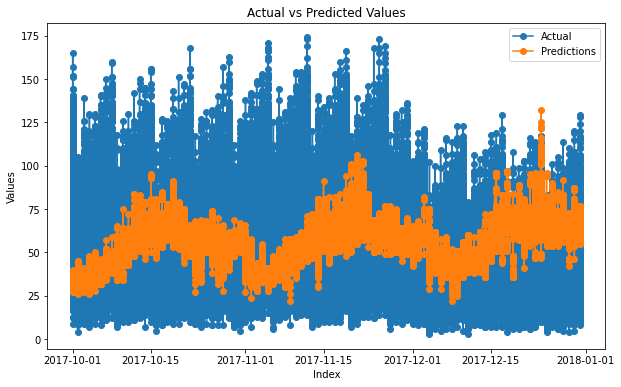

In [31]:
# plot forecasted vs real values
plt.figure(figsize=(10, 6))

plt.plot(result_df.index, result_df['Actual'], label='Actual', marker='o')
plt.plot(result_df.index, result_df['Predictions'], label='Predictions', marker='o')

plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()



Hyperparameter optimization

In [32]:
# Apply GridSearch for model improvement
xgb_model = XGBRegressor()
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, scoring='neg_mean_absolute_error', cv=5)
grid_search_xgb.fit(X_train_t, y_train_t)

best_xgb_model = grid_search_xgb.best_estimator_
smape_xgb_test3, predictions_test1 = evaluate_model_on_test_set(best_xgb_model, X_test_t, y_test_t)

print(f'Best XGB Model Parameters: {grid_search_xgb.best_params_}')
print(f'SMAPE value for XGB Model: {smape_xgb_test3}')


Best XGB Model Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
SMAPE value for XGB Model: 65.00861736033913


Model 2. Moving Average


In [33]:
#Create a function to calculate the next `periods` days using a 4-week moving average model for each store-item combination.
#For each future day, it uses past and forecasted values over a desired window

def recursive_moving_average_forecast(df, window=28, periods=90):
    """
    Recursively predict the next `periods` days using a 4-week moving average model for each store-item combination.

    Parameters:
    df (DataFrame): DataFrame containing the historical data with 'date', 'store', 'item', and 'sales' columns.
    window (int): The window size for the moving average in days. Default is 28 days (4 weeks).
    periods (int): Number of days to forecast. Default is 90 days.

    Returns:
    DataFrame: DataFrame containing the forecasted values for each store-item combination.
    """
    # Convert 'date' to datetime and set as index
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')

    all_forecasts = pd.DataFrame()

    for (store, item), group in df.groupby(['store', 'item']):
        sales_data = group['sales'].tolist()
        forecasts = []

        for day in range(periods):
            # Get the last 'window' days for the moving average calculation, including the forecasts
            if len(sales_data) >= window:
                window_data = sales_data[-window:]
            else:
                window_data = sales_data

            avg_sales = sum(window_data) / len(window_data)
            forecasts.append(avg_sales)

            # Use the forecast as 'actual' for next predictions
            sales_data.append(avg_sales)

        last_date = group.index[-1]
        forecast_dates = pd.date_range(start=last_date, periods=periods + 1, closed='right')
        forecast_df = pd.DataFrame({'date': forecast_dates, 'forecast': forecasts, 'store': store, 'item': item})
        all_forecasts = pd.concat([all_forecasts, forecast_df])

    all_forecasts = all_forecasts.set_index('date')
    return all_forecasts

In [ ]:
forecast = recursive_moving_average_forecast(X_train.reset_index(), window=28, periods=90)
forecast = forecast.reset_index()
forecast.head()

In [35]:
# Convert 'ds' in prophet_df to datetime if it's not already

forecast['date'] = pd.to_datetime(forecast['date'])
result_MA = X_test.merge(forecast, left_on=["date","store","item"] ,right_on= ['date', 'store', 'item'], how='inner').dropna()
print(mean_absolute_error(result_MA["sales"], result_MA["forecast"]))

12.017324298195101


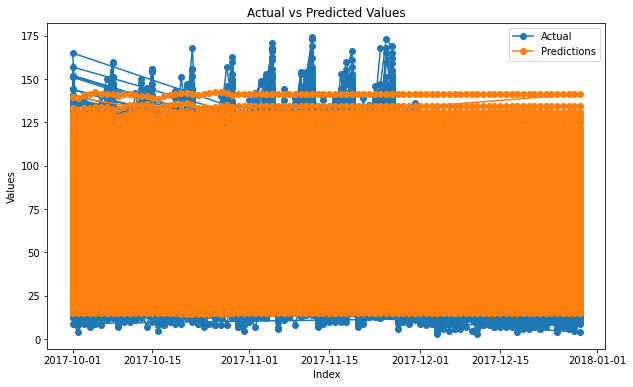

In [44]:
# plot forecasted vs real values
plt.figure(figsize=(10, 6))

plt.plot(result_MA.date, result_MA['sales'], label='Actual', marker='o')
plt.plot(result_MA.date, result_MA['forecast'], label='Predictions', marker='o')

plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

Model 3. Prophet

In [36]:
def train_prophet_models(df):
    # Reset index and rename columns
    df = df.reset_index().rename(columns={'date': 'ds', 'sales': 'y'})

    # Identify unique store-item combinations
    unique_combinations = df[['store', 'item']].drop_duplicates()

    # Dictionary to store models for each combination
    models = {}

    # Train a model for each combination
    for index, row in unique_combinations.iterrows():
        store_item_df = df[(df['store'] == row['store']) & (df['item'] == row['item'])].copy()

        # Initialize and fit Prophet model
        model = Prophet()
        model.fit(store_item_df)

        # Store the model with a unique key
        models[(row['store'], row['item'])] = model
    return models


In [37]:
# suppress informational messages
import logging

# Set the logging level to WARNING to suppress informational messages
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

In [38]:
def predict_with_prophet(models, test_df, periods):
    # Initialize an empty DataFrame for all forecasts
    all_forecasts = pd.DataFrame()

    # Iterate over each unique store-item combination in the test dataset
    for (store, item), group in test_df.groupby(['store', 'item']):
        model = models.get((store, item))
        if model:
            # Create future dataframe for prediction
            future = model.make_future_dataframe(periods=periods)

            # Predict
            forecast = model.predict(future)

            # Add 'store' and 'item' columns to the forecast DataFrame
            forecast['store'] = store
            forecast['item'] = item

            # Append the forecast to the overall DataFrame
            all_forecasts = pd.concat([all_forecasts, forecast])

    return all_forecasts

In [ ]:
# Example usage
# df should be your dataframe with 'date', 'sales', 'store', and 'item' columns for training
trained_models = train_prophet_models(X_train)

# test_df should be your test dataset with 'date', 'store', and 'item' columns
forecast = predict_with_prophet(trained_models, X_test, periods=90)


In [40]:
X_test = X_test.reset_index()

X_test['date'] = pd.to_datetime(X_test['date'])

# Convert 'ds' in prophet_df to datetime if it's not already
forecast['ds'] = pd.to_datetime(forecast['ds'])

forecast = forecast[["ds","yhat","store","item"]]

result_prophet = X_test.merge(forecast, left_on=["date","store","item"] ,right_on= ['ds', 'store', 'item'], how='inner').dropna()

In [42]:
print(mean_absolute_error(result_prophet["sales"], result_prophet["yhat"]))

6.1828498687281686


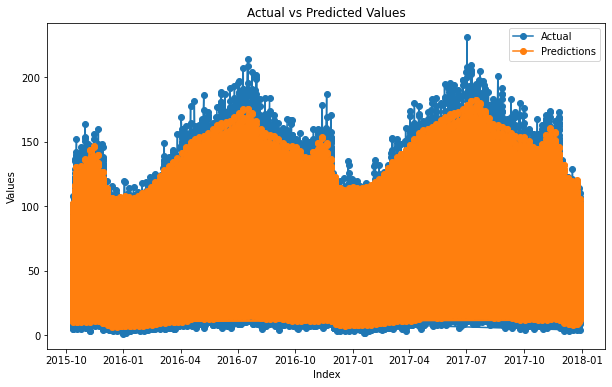

In [43]:
# plot forecasted vs real values
plt.figure(figsize=(10, 6))

plt.plot(result_prophet.date, result_prophet['sales'], label='Actual', marker='o')
plt.plot(result_prophet.date, result_prophet['yhat'], label='Predictions', marker='o')

plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()